The following block performs value iteration for the slippery version of FrozenLake with an insertible grid. It generates (using dynamic programming) the optimal value and policy that we compare against. 


In [5]:
import numpy as np

# Define a dynamic FrozenLake grid (changeable size)
grid_str = [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
]

# Convert list of strings to a NumPy array
grid = np.array([list(row) for row in grid_str])

# Create a boolean mask for terminal states (H and G)
terminal_states = (grid == "H") | (grid == "G")

# Flatten if needed for a 1D state space representation
terminal_states = terminal_states.flatten()

num_rows, num_cols = grid.shape
num_states = num_rows * num_cols  # Total states
num_actions = 4  # Left, Down, Right, Up
gamma = 0.9  # Discount factor
theta = 1e-50  # Convergence threshold
initial_state = 0  # Start state

# Action mapping (dx, dy)
action_to_delta = {
    0: (0, -1),  # Left
    1: (1, 0),   # Down
    2: (0, 1),   # Right
    3: (-1, 0)   # Up
}

# Convert 2D coordinates to 1D state index
def state_index(row, col):
    return row * num_cols + col

# Get next state given action, handling boundaries
def get_next_state(row, col, action):
    dr, dc = action_to_delta[action]
    new_row, new_col = row + dr, col + dc

    # Check boundaries
    if new_row < 0 or new_row >= num_rows or new_col < 0 or new_col >= num_cols:
        return state_index(row, col)  # Stay in place

    return state_index(new_row, new_col)

# Initialize transition probability matrix
P = {s: {a: [] for a in range(num_actions)} for s in range(num_states)}

# Identify terminal (non-updating) states
non_updating_states = set()

# Fill in the transition probabilities
for row in range(num_rows):
    for col in range(num_cols):
        s = state_index(row, col)

        # Mark hole and goal states as non-updating
        if grid[row, col] in {'H', 'G'}:
            non_updating_states.add(s)

        for a in range(num_actions):
            possible_transitions = []
            for next_a in [(a + 1) % 4, a, (a - 1) % 4]:  # Left turn, Forward, Right turn
                next_s = get_next_state(row, col, next_a)
                
                # Default reward and terminal state handling
                reward = 0  # Default reward
                if grid[next_s // num_cols, next_s % num_cols] == 'H':  # Hole → Reset to start
                    next_s = initial_state  
                elif grid[next_s // num_cols, next_s % num_cols] == 'G':  # Goal → Reward 1, then reset
                    reward = 100
                    next_s = initial_state  

                possible_transitions.append((1/3, next_s, reward))

            P[s][a] = possible_transitions  # Store transition probabilities

# Value Iteration Algorithm
def value_iteration():
    V = np.zeros(num_states)  # Initialize all state values to 0
    policy = np.zeros(num_states, dtype=int)  # Store best actions

    while True:
        delta = 0
        for s in range(num_states):
            if s in non_updating_states:  # Skip updating hole/goal states
                continue
            
            v = V[s]
            action_values = []
            for a in range(num_actions):
                q_value = sum(prob * (reward + gamma * V[next_s]) 
                              for prob, next_s, reward in P[s][a])
                action_values.append(q_value)

            V[s] = max(action_values)  # Bellman update
            policy[s] = np.argmax(action_values)  # Best action
            delta = max(delta, abs(v - V[s]))  # Check convergence

        if delta < theta:  # Stop if values have converged
            break

    return V, policy



def reg_value_iteration(eta_rho):
    V = np.zeros(num_states)  # Initialize state values
    policy = np.zeros((num_states, num_actions))  # Store probability distributions over actions

    while True:
        delta = 0
        for s in range(num_states):
            if s in non_updating_states:  # Skip updating hole/goal states
                continue
            
            v = V[s]
            action_values = np.zeros(num_actions)
            for a in range(num_actions):
                action_values[a] = sum(prob * (reward + gamma * V[next_s])
                                       for prob, next_s, reward in P[s][a])
            
            # Apply the numerically stable log-sum-exp trick
            max_Q = np.max(action_values / eta_rho)  # Max Q-value for stability
            exp_values = np.exp((action_values / eta_rho) - max_Q)  # Shifted exponentials
            sum_exp = np.sum(exp_values)  # Stable sum of exponentials

            V[s] = eta_rho * (max_Q + np.log(sum_exp))  # Compute stable softmax value update
            policy[s] = exp_values / sum_exp  # Compute stable softmax policy
            
            delta = max(delta, abs(v - V[s]))  # Check for convergence

        if delta < theta:  # Stop if values have converged
            break
    
    return V, policy




def value_calc(rho_pol, theta):
    V = np.zeros(num_states)

    while True:
        delta = 0
        for s in range(num_states-1,-1,-1):
            if s in non_updating_states: 
                continue

            v = V[s]
            action_values = 0
            for a in range(num_actions):
                # Compute expected value of state `s` under stochastic policy
                action_values += rho_pol[s, a] * sum(prob * (reward + gamma * V[next_s]) 
                                                    for prob, next_s, reward in P[s][a])
            V[s] = action_values  # Assign the value of the state
            delta = max(delta, abs(v - V[s]))  # Check convergence

        if delta < theta:  # Stop if values have converged
            break

    return V

def reg_value_calc(rho_pol, theta, eta_rho):
    reg_V = np.zeros(num_states)

    while True:
        delta = 0
        for s in range(num_states-1,-1,-1):
            if s in non_updating_states: 
                continue

            v = reg_V[s]
            action_values = 0
            for a in range(num_actions):
                # Compute expected value of state `s` under stochastic policy
                action_values += rho_pol[s, a] * sum(prob * (reward + gamma * reg_V[next_s]) 
                                                    for prob, next_s, reward in P[s][a])
            reg_V[s] = action_values-eta_rho*sum(rho_pol[s]*np.log(rho_pol[s]))  # Assign the value of the state
            delta = max(delta, abs(v - reg_V[s]))  # Check convergence

        if delta < theta:  # Stop if values have converged
            break

    return reg_V

def compute_value_function_error(agent, current_V: np.ndarray,current_V_reg: np.ndarray, optimal_V: np.ndarray, optimal_V_reg: np.ndarray,reg_V_optimal: np.ndarray, terminal_states: np.ndarray) -> tuple[float,float,float,float]:
    V_MSE = np.linalg.norm(agent.V[~terminal_states] - optimal_V[~terminal_states])/np.linalg.norm(optimal_V[~terminal_states])
    V_MSE_reg = np.linalg.norm(agent.V[~terminal_states]-reg_V_optimal[~terminal_states])/np.linalg.norm(reg_V_optimal[~terminal_states])
    V_current_MSE = np.linalg.norm(current_V[~terminal_states]-optimal_V[~terminal_states])/np.linalg.norm(optimal_V[~terminal_states])
    V_current_MSE_reg = np.linalg.norm(current_V[~terminal_states]-optimal_V_reg[~terminal_states])/np.linalg.norm(optimal_V_reg[~terminal_states])
    V_current_MSE_reg2 = np.linalg.norm(current_V_reg[~terminal_states]-reg_V_optimal[~terminal_states])/np.linalg.norm(reg_V_optimal[~terminal_states])
    return V_MSE, V_MSE_reg, V_current_MSE, V_current_MSE_reg,V_current_MSE_reg2

def compute_policy_error(agent_pol, terminal_states, reg_opt_pol):
    frob = np.linalg.norm((agent_pol[~terminal_states]-reg_opt_pol[~terminal_states]))/np.linalg.norm(reg_opt_pol[~terminal_states])
    KLdiv =np.sum(reg_opt_pol[~terminal_states] * np.log(reg_opt_pol[~terminal_states] / agent_pol[~terminal_states]), axis=(0, 1))
    return frob, KLdiv

def compute_value_function_target_error(agent, terminal_states) -> np.ndarray:
    # Initialize the target error vector for the value function with zeros.
    target_V = np.zeros(num_states)
    
    # Iterate over each state and action
    for s in range(num_states):
        if terminal_states[s]:
            continue
        for a in range(num_actions):
            # Create a dictionary to aggregate transition probabilities for each s'
            trans_probs = {}
            for (p, s_next, _) in P[s][a]:
                # Sum probabilities if multiple transitions lead to the same next state.
                trans_probs[s_next] = trans_probs.get(s_next, 0) + p
                
            # For each possible s' state, add the corresponding contribution.
            for s_prime in range(num_states):
                delta = 1 if s == s_prime else 0
                prob = trans_probs.get(s_prime, 0)
                target_V[s_prime] += agent.rho[s, a] * (delta - agent.gamma * prob)
                
    # Normalize by eta_V as required
    target_V /= agent.eta_V
    # Calculate the MSE
    target_V_MSE = np.linalg.norm(target_V[~terminal_states]-agent.V[~terminal_states])/np.linalg.norm(target_V[~terminal_states])
    return target_V_MSE


# Run Value Iteration
V_optimal, optimal_policy = value_iteration()
reg_V_optimal, reg_optimal_policy = reg_value_iteration(eta_rho=0.1)

V_reg_V_optimal = value_calc(reg_optimal_policy,1e-50)

Mse_V_reg_opt = np.sqrt(np.mean((V_optimal[~terminal_states]-V_reg_V_optimal[~terminal_states])**2))/np.linalg.norm(V_optimal[~terminal_states])

# Print Results
print("Optimal Value Function:")
print(V_optimal.reshape(num_rows, num_cols))

print("\nOptimal Policy (0:Left, 1:Down, 2:Right, 3:Up):")
optimal_policy_grid = np.array(optimal_policy).reshape(num_rows, num_cols)
print(optimal_policy_grid)

print("\nOptimal Regularized Policy Value :")
print(reg_V_optimal.reshape(num_rows, num_cols))

print("\nOptimal Regularized Policy, Unregularized Value Function:")
print(V_reg_V_optimal.reshape(num_rows, num_cols))

print("\n rel MSE Optimal Regularized Value vs Optimal Value:")
print(Mse_V_reg_opt)

Optimal Value Function:
[[ 7.49254618  7.38078907  9.61753787  7.33289316]
 [ 9.99006157  0.         15.06013262  0.        ]
 [15.81759749 26.9176659  33.09035803  0.        ]
 [ 0.         40.81759749 68.32339491  0.        ]]

Optimal Policy (0:Left, 1:Down, 2:Right, 3:Up):
[[0 1 0 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]

Optimal Regularized Policy Value :
[[ 8.11576246  8.03109114 10.22638957  8.00364008]
 [10.50873024  0.         15.61265808  0.        ]
 [16.17343198 27.22902364 33.4686962   0.        ]
 [ 0.         41.12128397 68.72063894  0.        ]]

Optimal Regularized Policy, Unregularized Value Function:
[[ 7.38887412  7.27031032  9.52989478  7.23285058]
 [ 9.92452363  0.         14.98557644  0.        ]
 [15.76931404 26.87247442 33.03505496  0.        ]
 [ 0.         40.77054575 68.25879899  0.        ]]

 rel MSE Optimal Regularized Value vs Optimal Value:
0.00080657589530906


The following class captures the PGDA Agent (for tabular RL) with the following features:

- Structured Buffer (one dict for each (s,a)-pair) with a max size of max_buffer
- Currently: delta the lower bound for the rho projection to prohibit early numerical stability problems with the rho projection
- Option to insert fixed policy
- Option to follow epsilon adapted on-policy exploration with decaying epsilon (initial, decay, final epsilon)
- Optional lower bound for alpha and beta to reduce length of learning 

In [ ]:
import numpy as np
import gymnasium as gym
from collections import defaultdict, deque
import random
from scipy.optimize import root_scalar

class PGDAAgent:
    def __init__(
        self,
        env: gym.Env,
        num_states: int,
        num_actions: int,
        gamma: float,
        C_r: float,
        delta: float,
        eta_V: float,
        eta_rho: float,
        alpha_schedule,  # e.g. lambda n: 1.0/n
        beta_schedule,   # e.g. lambda n: 1.0/(1+n*np.log(max(n,2)))
        max_buffer: int,
        m: int = 32,     # minibatch size for ρ update sampling from (s,a) bin
        D: int = 1,      # number of incoming (s,a) pairs to sample (without replacement) for V update
        fixed_policy: np.ndarray = None,
        use_epsilon_greedy: bool = True,
        initial_epsilon: float = 1,
        epsilon_decay: float = 5e-06,
        final_epsilon: float = 0.01,
        final_alpha: float = 0.0,
        final_beta: float = 0.0,
        warm_start_iters: float = 0.0,
        flat_start_a: int = 0,
        flat_start_b: int = 0,
        decay_scale: int = 1,
        state_specific_exploration: bool = False
    ):
        """
        Initialize the PGDA-RL agent with a tabular replay buffer.
        
        Args:
            env: Gym environment.
            num_states: Number of states (0,...,num_states-1).
            num_actions: Number of actions.
            gamma: Discount factor.
            C_r: Reward upper bound.
            delta: Delta for H projection.
            eta_V: Regularization for V update.
            eta_rho: Regularization for ρ update.
            alpha_schedule: Function: visitation_count -> V learning rate.
            beta_schedule: Function: visitation_count -> ρ learning rate.
            max_buffer: Maximum transitions stored per (s,a) bin.
            m: Number of draws (with replacement) from (s,a) bin for ρ update.
            D: Number of (s,a) pairs (drawn without replacement) from incoming_sa for V update.
            fixed_policy: Optional fixed policy (if provided).
            use_epsilon_greedy: Optional epsilon greedy exploration.
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            final_alpha: Optional final alpha value
            final_beta: Optional final beta value
            warm_start_iters: Optional number of update steps without decreasing step sizes
            flat_start_a: Optional update iteration where the warm_start begins for alpha
            flat_start_b: Optional update iteration where the warm_start begins for beta
            decay_scale: Scaling parameter for the step size schedule 
            state_specific_exploration: Optional possibility to adjust the epsilon exploration to be state-specific
        """
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        self.C_r = C_r
        self.delta = delta
        self.eta_V = eta_V
        self.eta_rho = eta_rho
        self.alpha_schedule = alpha_schedule
        self.beta_schedule = beta_schedule
        self.max_buffer = max_buffer
        self.m = m
        self.D = D
        self.fixed_policy = fixed_policy
        self.use_epsilon_greedy = use_epsilon_greedy
        self.initial_epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.final_alpha = final_alpha
        self.final_beta = final_beta
        self.warm_start_iters = warm_start_iters
        self.flat_start_a = flat_start_a
        self.flat_start_b = flat_start_b
        self.decay_scale = decay_scale
        self.state_specific_exploration = state_specific_exploration

        # Initialize V and ρ.
        self.V = np.ones(num_states)
        #self.V = np.array([0.77,0.81,0.85,0.81,0.81,0,0.90,0,0.85,0.9,0.94,0,0,0.94,0.99,0])
        self.rho = np.ones((num_states, num_actions))
        
        # Visitation counters.
        self.state_visits = np.zeros(num_states)
        self.state_action_visits = np.zeros((num_states, num_actions))
        
        # For each (s,a), store a deque of transitions (s_next, reward).
        self.replay_buffer_sa = defaultdict(lambda: deque(maxlen=self.max_buffer))
        
        if self.state_specific_exploration:
            self.epsilon = np.full(self.num_states, self.initial_epsilon,dtype=np.float64)  # Vector of epsilons
        else:
            # Epsilon parameter for get_action (for epsilon-greedy variant).
            self.epsilon = initial_epsilon  # default value; can be updated externally

        # For each state s, store a set of (s,a) pairs that transitioned to s.
        self.incoming_sa = defaultdict(set)
                
        # Compute H bounds.
        self.H_bounds = self.compute_H_bounds()
        


    def compute_H_bounds(self):
        """Compute H bounds as (C_rho^L - delta, C_rho^U + delta)."""
        U_G = np.log(self.num_actions)  # using U_G = ln(|A|)
        C_rho_U = (self.num_states * self.eta_V * (self.C_r + self.eta_rho * U_G)) / ((1 - self.gamma) ** 2)
        C_rho_L = (self.eta_V * (self.C_r + self.eta_rho * U_G) / (1 - self.gamma)) * np.exp(
            - (self.C_r + self.eta_rho*U_G) / (self.eta_rho * (1 - self.gamma))
        )
        return (C_rho_L+self.delta, C_rho_U + self.delta)
    
    def get_action(self, state: int) -> int:
        """
        Return an action. If fixed_policy is set, use that.
        If use_epsilon_greedy is True, then with probability epsilon choose uniformly; otherwise use policy.
        Otherwise, use ρ-based policy: π(a|s) ∝ ρ(s,a).
        """
        if self.fixed_policy is not None:
            probs = self.fixed_policy[state]
        else:
            probs = self.rho[state] / np.sum(self.rho[state])
        
        if self.use_epsilon_greedy:
            eps = self.epsilon[state] if self.state_specific_exploration else self.epsilon
            if np.random.rand() < eps:
                return self.env.action_space.sample()

        return np.random.choice(self.num_actions, p=probs)
    
    def _sample_minibatch_sa(self, s: int, a: int):
        """
        Sample m transitions (with replacement) from the (s,a) bin.
        Avoid extra copying by directly using random.choices.
        """
        buffer_sa = self.replay_buffer_sa[(s, a)]
        if not buffer_sa:
            return []  # empty list if no transitions.
        return random.choices(buffer_sa, k=self.m)
    
    def _estimate_transition_probability_sa(self, batch, s_prime: int) -> float:
        """
        Vectorized computation: given batch as a list of (s_next, reward),
        count how many s_next equal s_prime.
        """
        if not batch:
            return 0.0
        # Convert list of tuples to numpy array of s_next values.
        s_next_vals = np.array([t[0] for t in batch])
        return np.mean(s_next_vals == s_prime)
    
    def update(self, s_prev: int, a_prev: int, s: int, reward: float):
        """
        Perform one update step.
          - ρ update: sample from the (s_prev,a_prev) bin.
          - V update: sample from incoming_sa for target state s.
        """
        # Update visitation counts.
        self.state_visits[s_prev] += 1
        self.state_action_visits[s_prev, a_prev] += 1
        
        # Add new transition to the (s_prev,a_prev) buffer.
        self.replay_buffer_sa[(s_prev, a_prev)].append((s, reward))
        # Record that (s_prev,a_prev) produced a transition into s.
        self.incoming_sa[s].add((s_prev, a_prev))
        
        # ------------------ ρ Update ------------------
        batch_rho = self._sample_minibatch_sa(s_prev, a_prev)
        # Compute the contribution: estimate expected V for transitions from (s_prev,a_prev)
        if batch_rho:
            # For each possible next state, we want to compute the fraction of draws equal to that state.
            # Instead of a loop over states, we compute a histogram.
            s_next_array = np.array([t[0] for t in batch_rho])
            # Count occurrences for all states at once.
            counts = np.bincount(s_next_array, minlength=self.num_states)
            probabilities = counts / len(s_next_array)
            # Dot product with V gives the expected V.
            sum_term = np.dot(probabilities, self.V)
        else:
            sum_term = 0.0
        
        tilde_rho = np.sum(self.rho[s_prev, :])
        grad_rho = (-self.V[s_prev] + reward + self.gamma * sum_term 
                    - self.eta_rho * np.log(self.rho[s_prev, a_prev] / tilde_rho))
        beta = self.beta_schedule(self.state_action_visits[s_prev, a_prev],self.flat_start_b,self.warm_start_iters,self.decay_scale)
        new_rho_value = self.rho[s_prev, a_prev] + max(beta,self.final_beta) * grad_rho
        # Directly use the stored H_bounds (attribute lookup is negligible if done once)
        self.rho[s_prev, a_prev] = np.clip(new_rho_value, *self.H_bounds)
        
        # ------------------ V Update ------------------
        #incoming = self.incoming_sa[s]
        # If no (s,a) pair has ever transitioned to s, do not update V(s).
        #if not incoming:
        #    return
        
        # Sample D (without replacement) from incoming (s,a) pairs.
        #D_sample = random.sample(list(incoming), min(self.D, len(incoming)))
        grad_V = self.eta_V * self.V[s]-sum(self.rho[s])

        # Second sum: transition probability term for all incoming (s', a)
        for (s_, a_) in self.incoming_sa[s]:
            if not self.replay_buffer_sa[(s_, a_)]:
                continue
            
            # Estimate transition probability using sampled experience
            if (s_,a_)==(s_prev, a_prev):
                draws = batch_rho
            else:
                draws = random.choices(self.replay_buffer_sa[(s_, a_)], k=self.m)  # draws with replacement
            draws_array = np.array([x[0] for x in draws])
            p_hat = np.mean(draws_array == s)  # Probability of transitioning to s

            grad_V += self.rho[s_, a_] * self.gamma * p_hat

        # Learning rate adjustment
        alpha = self.alpha_schedule(self.state_visits[s], self.flat_start_a, self.warm_start_iters, self.decay_scale)
        self.V[s] -= max(alpha, self.final_alpha) * grad_V

    def decay_parameters(self, state: int=0):
        if self.state_specific_exploration:
            self.epsilon[state] = np.clip(self.epsilon[state] - self.epsilon_decay,self.final_epsilon, self.initial_epsilon)
        else:
            self.epsilon=np.clip(self.epsilon - self.epsilon_decay,self.final_epsilon, self.initial_epsilon)

The following block contains the initialization of the setup and a PGDA Agent specification for a single run of the FrozenLake environment. Note that the environment is adjusted such that transitions to terminal states are logged as transitions to the initial state to adjust the originally episodic environment to the infinite horizon MDP framework.

In [ ]:
n_episodes =100_000
n_total_episodes = 300_000
# Create a gymnasium environment.
desc = ["SFFF",
        "FFFH",
        "FFFH",
        "HFFG"]
#env = gym.make("FrozenLake-v1", desc=desc,is_slippery=True)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
#env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_total_episodes)

# Hyperparameters for our PGDA agent
num_states = env.observation_space.n      # e.g., 64 for an 8x8 FrozenLake
num_actions = env.action_space.n          # e.g., 4 actions
gamma = 0.9
C_r = 100
delta = 1e-50
eta_V = 0.1
eta_rho = 0.1
max_buffer=1_000

# --- Decay Scaling ---
# Introduce a scaling factor to slow down the decay.
# A higher decay_scale means the effective count increases more slowly.
decay_scale = 1000

# --- Determine the flat start iteration via root finding ---
# For alpha: we want to find the iteration where our decaying schedule reaches a target lower level.
# The following lambda is adjusted to use count/decay_scale.
alpha_k = lambda count: 0.01 - 1 / (10+(count))
result = root_scalar(alpha_k, bracket=[1, 100_000])
flat_start_a = np.ceil(result.root)

# Similarly for beta:
beta_k = lambda count: 0.005 - 1 / (1+(10+count) * np.log(max(10+count, 2)))
result = root_scalar(beta_k, bracket=[1, 100_000])
flat_start_b = np.ceil(result.root)

# --- Define step-size schedules ---
def alpha_schedule(count, flat_start_a, warm_start_iters, decay_scale):
    """Alpha schedule: decays until flat_start_a, holds constant for warm_start_iters, then resumes decay.
       The decay is slowed down by scaling the count by decay_scale.
    """
    if count < flat_start_a:
        return 1 / (10+(count))
    elif count < flat_start_a + warm_start_iters:
        # Hold constant at the lower level reached at flat_start_a.
        return 1 / (10+(flat_start_a))
    else:
        # Resume decay, subtracting the held iterations.
        return 1 / (10+((count - (warm_start_iters+flat_start_a)) / (decay_scale)+flat_start_a))

def beta_schedule(count, flat_start_b, warm_start_iters, decay_scale):
    """Beta schedule: decays until flat_start_b, holds constant for warm_start_iters, then resumes decay.
       The decay is slowed down by scaling the count by decay_scale.
    """
    if count < flat_start_b:
        return 1 / (1+(10+count) * np.log(max(count+10, 2)))
    elif count < flat_start_b + warm_start_iters:
        return 1 / (1+(10+flat_start_b) * np.log(max(flat_start_b+10, 2)))
    else:
        return 1 / (1+(10+(count - (warm_start_iters+flat_start_b)) / decay_scale+flat_start_b) * np.log(max(10+(count - (warm_start_iters+flat_start_b)) / decay_scale+flat_start_b, 2)))


# Mini-batch size for experience replay:
m = 10
D = 100
fixed_policy=None

initial_epsilon = 1
epsilon_decay = initial_epsilon / n_episodes  # reduce the exploration over time
final_epsilon = 0.01
final_beta = 0.00
final_alpha = 0.0

warm_start_iters = 1000

# Initialize the agent.
agent = PGDAAgent(
    env=env,
    num_states=num_states,
    num_actions=num_actions,
    gamma=gamma,
    C_r = C_r,
    delta = delta,
    eta_V=eta_V,
    eta_rho=eta_rho,
    alpha_schedule=alpha_schedule,
    beta_schedule=beta_schedule,
    max_buffer=max_buffer,
    m=m,
    D=1,
    fixed_policy=fixed_policy,
    use_epsilon_greedy=True,
    initial_epsilon = initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    final_beta=final_beta,
    final_alpha=final_alpha,
    warm_start_iters=warm_start_iters,
    flat_start_a=flat_start_a,
    flat_start_b=flat_start_b,
    decay_scale=decay_scale,
    state_specific_exploration=False
)

# Run episodes.
from tqdm import tqdm

# Lists to store the MSE values for the value and policy estimate

mse_values = []
mse_reg_values = []

Value_start_stoch = []
Value_total_MSE = []
Value_reg_total_MSE = []
Value_reg_total_MSE2 = []

rho_pol_opt_reg_MSE = []
rho_pol_opt_reg_KL =[]


MSE_freq = 10_000

#n_total_episodes = 100_000

# We assume an initial state s0 is obtained from env.reset()
s, info = env.reset()
# For the very first step, we need to sample an action.
a = agent.get_action(s)

MSE_count = 0

for episode in tqdm(range(n_total_episodes)):
    done = False
    # For each episode, we use the agent's current policy.
    # We keep track of the previous state and action for the update.
    # For the first step, we choose an initial action.
    a = agent.get_action(s)

    while not done:
        s_next, reward, terminated, truncated, info = env.step(a)
        done = terminated or truncated          
        # Update the agent with the previous transition.
        # Move to next state.
        if terminated:
            s_start, info = env.reset()
            agent.update(s,a,s_start,reward*100)
            s=s_start
        elif truncated:
            s, info = env.reset()
        else:         
            agent.update(s, a, s_next, reward)
            s = s_next
        # Choose next action according to the updated policy.
        a = agent.get_action(s)

        if agent.state_specific_exploration:
            agent.decay_parameters(s)

        # Compute MSE after every MSE_freq epsiodes
        MSE_count += 1
        if MSE_count == MSE_freq:
            #Reset MSE count
            MSE_count = 0
            
            #Extract policy from agents dual variable rho and calculate the unregularized value of the current policy
            agent_pol = agent.rho/np.sum(agent.rho,axis=1,keepdims=True)
            current_V = value_calc(agent_pol, theta = 1e-10)
            current_V_reg = reg_value_calc(agent_pol, theta=1e-10,eta_rho=agent.eta_rho)
            Value_start_stoch.append(current_V[0])
            
            #Value Coparisons (of current policy's values and of primal iterate)
            V_MSEs = compute_value_function_error(agent, current_V,current_V_reg, V_optimal, V_reg_V_optimal, reg_V_optimal, terminal_states)
            mse_values.append(V_MSEs[0])
            mse_reg_values.append(V_MSEs[1])
            Value_total_MSE.append(V_MSEs[2])
            Value_reg_total_MSE.append(V_MSEs[3])
            Value_reg_total_MSE2.append(V_MSEs[4])

        
            #Current Policy vs optimal regularized policy (unique)
            rho_err = compute_policy_error(agent_pol,terminal_states,reg_optimal_policy)
            rho_pol_opt_reg_MSE.append(rho_err[0])
            rho_pol_opt_reg_KL.append(rho_err[1])
            
    
    # Decay exploration parameter after the episode finishes
    if not agent.state_specific_exploration:
        agent.decay_parameters()

env.close()


100%|██████████| 300000/300000 [06:37<00:00, 753.89it/s]


The following block generates the comparison outputs

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/fx/lfrm6zj92fnb4t9zqvvx45c40000gn/T/ipykernel_24339/1270721282.py:31: SyntaxWarning: invalid escape sequence '\p'
  axes[2].plot(range(Plot_len), rho_pol_opt_reg_KL[0:Plot_len], label="$\pi_k, \pi^\star$ KL-Divergence", color="green")


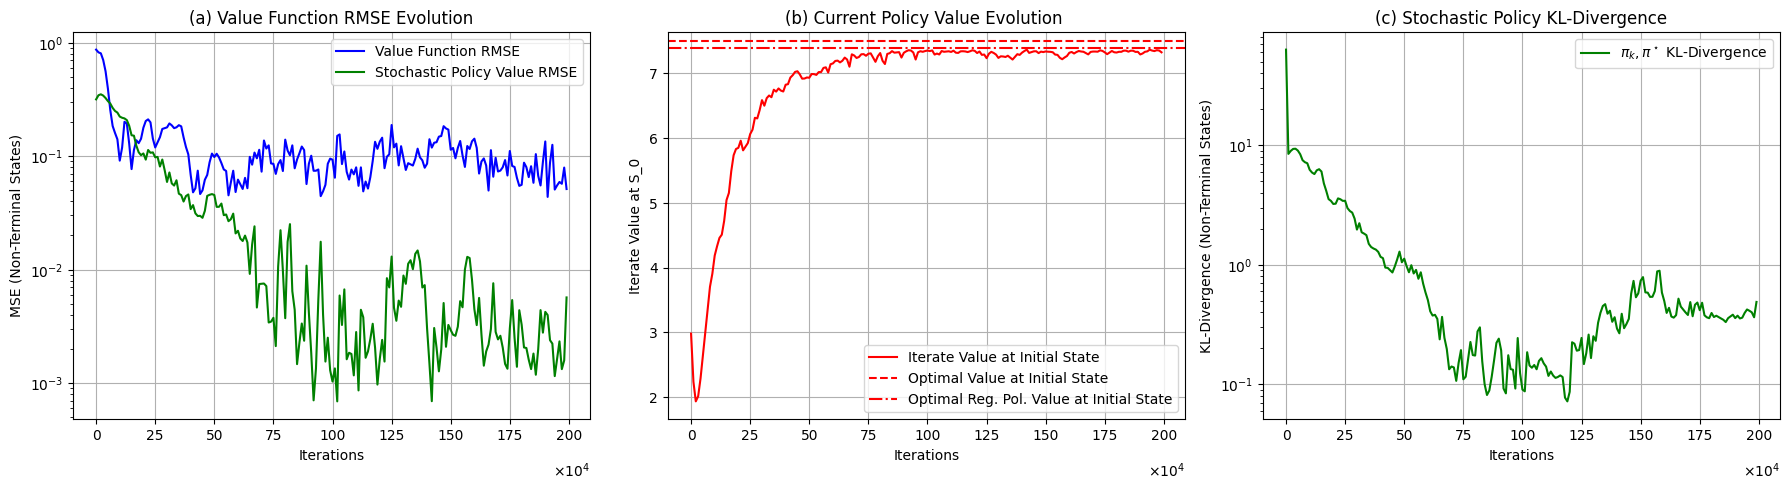

In [9]:
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

Plot_len = 200
# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Value Function MSE in the first subplot
axes[0].plot(range(Plot_len),mse_reg_values[0:Plot_len], label="Value Function RMSE", color="blue")
axes[0].plot(range(Plot_len), Value_reg_total_MSE2[0:Plot_len], label="Stochastic Policy Value RMSE", color="green")

#axes[0].plot(range(len(mse_reg_values)),np.sqrt(mse_reg_values)/np.linalg.norm(V_reg_V_optimal),label="Reg. Optimal Value RMSE")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("MSE (Non-Terminal States)")
axes[0].set_title("(a) Value Function RMSE Evolution")
axes[0].set_yscale("log")  # Set y-axis to log scale
axes[0].legend()
axes[0].grid(True)

# Plot Deterministic Policy MSE in the second subplot
axes[1].plot(range(Plot_len), Value_start_stoch[0:Plot_len], label="Iterate Value at Initial State", color="red")
axes[1].axhline(y=V_optimal[0], color='red', linestyle='--', label="Optimal Value at Initial State")
axes[1].axhline(y=V_reg_V_optimal[0], color='red', linestyle='-.', label="Optimal Reg. Pol. Value at Initial State")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Iterate Value at S_0")
axes[1].set_title(f"(b) Current Policy Value Evolution ")#(e_V,e_r,ds)={eta_V, eta_rho,decay_scale}")
axes[1].legend()
axes[1].grid(True)

# Plot Dual Policy vs Optimal Regularized Policy MSE in the third subplot 
axes[2].plot(range(Plot_len), rho_pol_opt_reg_KL[0:Plot_len], label="$\pi_k, \pi^\star$ KL-Divergence", color="green")
#axes[2].axhline(y=Mse_V_reg_opt, color="green", linestyle='-.', label="Optimal Reg. Value RMSE")
axes[2].set_xlabel("Iterations")
axes[2].set_ylabel("KL-Divergence (Non-Terminal States)")
axes[2].set_title("(c) Stochastic Policy KL-Divergence")
axes[2].set_yscale("log")  # Set y-axis to log scale
axes[2].legend()
axes[2].grid(True)


for ax in axes:
    ax.text(1.0, -0.15, r"$\times 10^4$", transform=ax.transAxes, ha="right", fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [13]:
print("Agent Value Function:")
print(current_V.reshape(num_rows, num_cols))

print("\nOptimal Regularized Policy, Unregularized Value Function:")
print(V_reg_V_optimal.reshape(num_rows, num_cols))

print("\nAgent primal Variable:")
print(agent.V.reshape(num_rows, num_cols))

print("\nAgent Regularized Value Function:")
print(current_V_reg.reshape(num_rows, num_cols))

print("\nReg Value Function:")
print(reg_V_optimal.reshape(num_rows,num_cols))

Agent Value Function:
[[ 3.71151589  3.995039    6.01229695  4.05578902]
 [ 5.02271319  0.         10.47946441  0.        ]
 [ 8.9895305  17.88281554 25.86011377  0.        ]
 [ 0.         29.2865255  60.94567141  0.        ]]

Optimal Regularized Policy, Unregularized Value Function:
[[ 7.38887412  7.27031032  9.52989478  7.23285058]
 [ 9.92452363  0.         14.98557644  0.        ]
 [15.76931404 26.87247442 33.03505496  0.        ]
 [ 0.         40.77054575 68.25879899  0.        ]]

Agent primal Variable:
[[ 8.84644381  6.46063813  9.07849762  9.2357959 ]
 [ 7.40720026  1.         12.12502292  1.        ]
 [12.21533192 17.75755803 21.75536395  1.        ]
 [ 1.         33.29473885 55.62695875  1.        ]]

Agent Regularized Value Function:
[[ 5.00702671  5.27627075  7.2433041   5.3368817 ]
 [ 6.29581052  0.         11.69693042  0.        ]
 [10.20514332 19.04877272 27.00787758  0.        ]
 [ 0.         30.45282433 62.09446828  0.        ]]

Reg Value Function:
[[ 8.11576246  8.03

The following block contains the initialization of the PGDA agent and repeated runs of the FrozenLake environment. Note that the environment is adjusted such that transitions to terminal states are logged as transitions to the initial state to adjust the originally episodic environment to the infinite horizon MDP framework.

In [16]:
import numpy as np
import gymnasium as gym
from collections import defaultdict
import random
from tqdm import tqdm
from scipy.optimize import root_scalar

# ------------------
# Parameters Setup
# ------------------

n_episodes = 100_000
n_total_episodes = 180_000  # total episodes for simulation
MSE_freq = 10_000
num_runs = 1  # run 10 independent initializations

desc = ["SHHH",
        "FFFH",
        "HFFH",
        "HHFG"]
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_total_episodes)

num_states = env.observation_space.n
num_actions = env.action_space.n
gamma = 0.9
C_r = 100
delta = 1e-50
eta_V = 0.1
eta_rho = 0.1
max_buffer = 10_000

# Decay scaling
decay_scale = 200

# Determine flat start iterations using root_scalar
alpha_k = lambda count: 0.01 - 1 / (10 + (count))
result = root_scalar(alpha_k, bracket=[1, 100_000])
flat_start_a = np.ceil(result.root)

beta_k = lambda count: 0.005 - 1 / (1 + (10 + count) * np.log(max(10 + count, 2)))
result = root_scalar(beta_k, bracket=[1, 100_000])
flat_start_b = np.ceil(result.root)

# Step size schedules (including the optional flat start)
def alpha_schedule(count, flat_start_a, warm_start_iters, decay_scale):
    if count < flat_start_a:
        return 1 / (10 + count)
    elif count < flat_start_a + warm_start_iters:
        return 1 / (10 + flat_start_a)
    else:
        return 1 / (10 + ((count - (flat_start_a+warm_start_iters)) / decay_scale + flat_start_a))

def beta_schedule(count, flat_start_b, warm_start_iters, decay_scale):
    if count < flat_start_b:
        return 1 / (1 + (10 + count) * np.log(max(count + 10, 2)))
    elif count < flat_start_b + warm_start_iters:
        return 1 / (1 + (10 + flat_start_b) * np.log(max(flat_start_b + 10, 2)))
    else:
        return 1 / (1 + (10 + (count - (flat_start_b+warm_start_iters)) / decay_scale + flat_start_b) *
                    np.log(max(10 + (count - (flat_start_b+warm_start_iters)) / decay_scale + flat_start_b, 2)))

# Hyperparameters for the transition probability estimaton and 
m = 10
D = 100
fixed_policy = None
initial_epsilon = 1
epsilon_decay = initial_epsilon / n_episodes
final_epsilon = 0.1
final_beta = 0.0
final_alpha = 0.0
warm_start_iters = 1000

# ------------------
# Containers for metrics over runs
# ------------------
all_mse_values = []
all_mse_reg_values = []
all_Value_start_stoch = []
all_Value_total_MSE = []
all_Value_reg_total_MSE = []
all_Value_reg_total_MSE2 = []
all_rho_pol_opt_reg_MSE = []
all_rho_pol_opt_reg_KL = []

for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    # Reinitialize environment (if needed) and agent for each run.
    s, info = env.reset()
    
    # Create a new agent instance for this run.
    agent = PGDAAgent(
        env=env,
        num_states=num_states,
        num_actions=num_actions,
        gamma=gamma,
        C_r=C_r,
        delta=delta,
        eta_V=eta_V,
        eta_rho=eta_rho,
        alpha_schedule=alpha_schedule,
        beta_schedule=beta_schedule,
        max_buffer=max_buffer,
        m=m,
        D=1,
        fixed_policy=fixed_policy,
        use_epsilon_greedy=True,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        final_beta=final_beta,
        final_alpha=final_alpha,
        warm_start_iters=warm_start_iters,
        flat_start_a=flat_start_a,
        flat_start_b=flat_start_b,
        decay_scale=decay_scale,
        state_specific_exploration=False
    )
    
    # Initialize lists to store metrics for this run.
    mse_values = []
    mse_reg_values = []
    Value_start_stoch = []
    Value_total_MSE = []
    Value_reg_total_MSE = []
    Value_reg_total_MSE2 = []
    rho_pol_opt_reg_MSE = []
    rho_pol_opt_reg_KL = []
    
    MSE_count = 0

    # Run episodes for this initialization.
    for episode in tqdm(range(n_total_episodes), desc=f"Run {run+1}"):
        done = False
        a = agent.get_action(s)
        while not done:
            s_next, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            if terminated:
                s_start, info = env.reset()
                agent.update(s, a, s_start, reward * 100)
                s = s_start
            elif truncated:
                s, info = env.reset()
            else:
                agent.update(s, a, s_next, reward)
                s = s_next
            a = agent.get_action(s)
            if agent.state_specific_exploration:
                agent.decay_parameters(s)
            
            MSE_count += 1
            if MSE_count == MSE_freq:
                MSE_count = 0
                # Compute current policy and values.
                agent_pol = agent.rho / np.sum(agent.rho, axis=1, keepdims=True)
                current_V = value_calc(agent_pol, theta=1e-10)
                current_V_reg = reg_value_calc(agent_pol, theta=1e-10, eta_rho=agent.eta_rho)
                Value_start_stoch.append(current_V[0])
                
                V_MSEs = compute_value_function_error(agent, current_V, current_V_reg,
                                                       V_optimal, V_reg_V_optimal,
                                                       reg_V_optimal, terminal_states)
                mse_values.append(V_MSEs[0])
                mse_reg_values.append(V_MSEs[1])
                Value_total_MSE.append(V_MSEs[2])
                Value_reg_total_MSE.append(V_MSEs[3])
                Value_reg_total_MSE2.append(V_MSEs[4])
                
                rho_err = compute_policy_error(agent_pol, terminal_states, reg_optimal_policy)
                rho_pol_opt_reg_MSE.append(rho_err[0])
                rho_pol_opt_reg_KL.append(rho_err[1])
        
        if not agent.state_specific_exploration:
            agent.decay_parameters()

    # Store the metric vectors for this run.
    all_mse_values.append(mse_values)
    all_mse_reg_values.append(mse_reg_values)
    all_Value_start_stoch.append(Value_start_stoch)
    all_Value_total_MSE.append(Value_total_MSE)
    all_Value_reg_total_MSE.append(Value_reg_total_MSE)
    all_Value_reg_total_MSE2.append(Value_reg_total_MSE2)
    all_rho_pol_opt_reg_MSE.append(rho_pol_opt_reg_MSE)
    all_rho_pol_opt_reg_KL.append(rho_pol_opt_reg_KL)

env.close()



Run 1/1


Run 1: 100%|██████████| 180000/180000 [04:06<00:00, 730.87it/s]


The following block generates the plots of Value relative MSEs, Current Policy Evolution, Stochastic Policy KL-Divergence with 1.96 standard deviation bars.

<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
/var/folders/fx/lfrm6zj92fnb4t9zqvvx45c40000gn/T/ipykernel_24339/2846947117.py:52: SyntaxWarning: invalid escape sequence '\p'
  axes[2].plot(range(Plot_len), rho_kl_mean, label="$\pi_k, \pi^\star$ KL-Divergence", color="green")


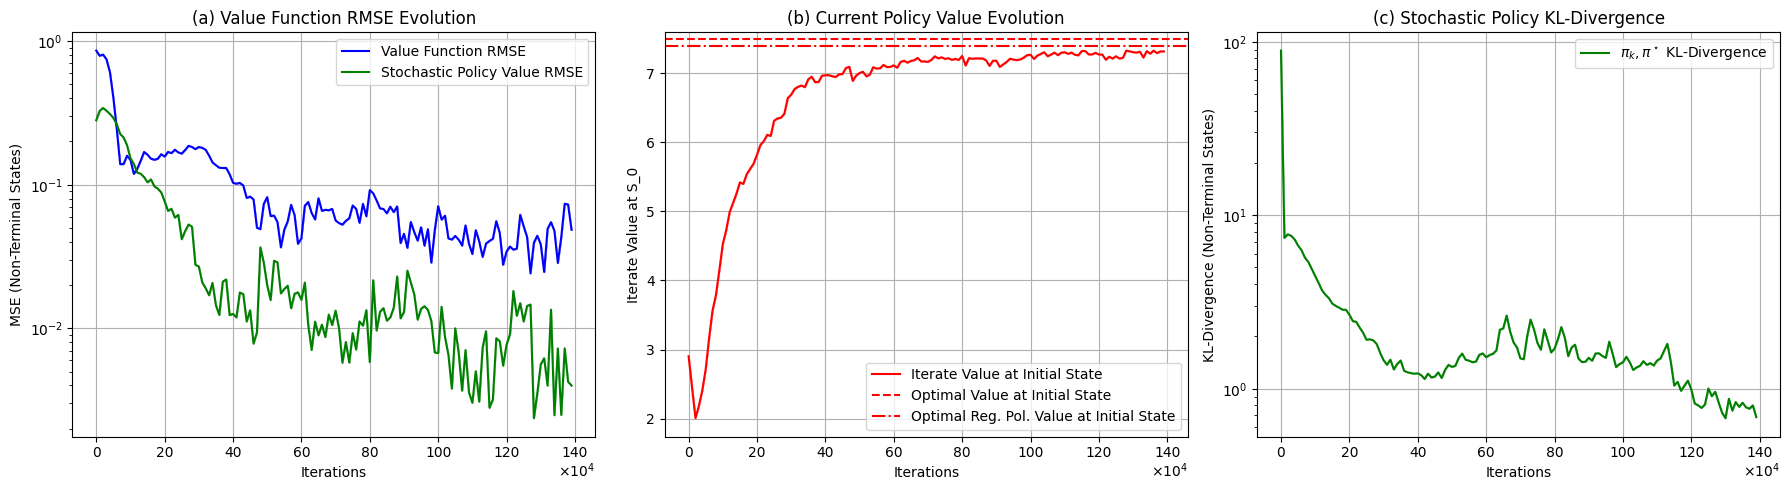

In [18]:
import numpy as np
from matplotlib import pyplot as plt

def compute_mean_ci(data_list, plot_len):
    """Compute mean and two std. deviation interval across multiple runs."""
    data_array = np.array([run[:plot_len] for run in data_list])  # Trim to same length
    mean = np.mean(data_array, axis=0)
    std_error = np.std(data_array, axis=0) / np.sqrt(len(data_list))  # Standard error
    ci_upper = mean + 2 * std_error
    ci_lower = mean - 2 * std_error
    return mean, ci_upper, ci_lower

Plot_len = 140

# Compute mean and confidence intervals for each metric
mse_reg_mean, mse_reg_ci_upper, mse_reg_ci_lower = compute_mean_ci(all_mse_reg_values, Plot_len)
value_mse_mean, value_mse_ci_upper, value_mse_ci_lower = compute_mean_ci(all_Value_reg_total_MSE2, Plot_len)
value_start_mean, value_start_ci_upper, value_start_ci_lower = compute_mean_ci(all_Value_start_stoch, Plot_len)
rho_kl_mean, rho_kl_ci_upper, rho_kl_ci_lower = compute_mean_ci(all_rho_pol_opt_reg_KL, Plot_len)

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Subplot (a): Value Function MSE ---
axes[0].plot(range(Plot_len), mse_reg_mean, label="Value Function RMSE", color="blue")
axes[0].fill_between(range(Plot_len), mse_reg_ci_lower, mse_reg_ci_upper, color="blue", alpha=0.3)  # CI shading

axes[0].plot(range(Plot_len), value_mse_mean, label="Stochastic Policy Value RMSE", color="green")
axes[0].fill_between(range(Plot_len), value_mse_ci_lower, value_mse_ci_upper, color="green", alpha=0.3)

axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("MSE (Non-Terminal States)")
axes[0].set_title("(a) Value Function RMSE Evolution")
axes[0].set_yscale("log")  # Log scale
axes[0].legend()
axes[0].grid(True)

# --- Subplot (b): Policy Value at Initial State ---
axes[1].plot(range(Plot_len), value_start_mean, label="Iterate Value at Initial State", color="red")
axes[1].fill_between(range(Plot_len), value_start_ci_lower, value_start_ci_upper, color="red", alpha=0.3)

axes[1].axhline(y=V_optimal[0], color='red', linestyle='--', label="Optimal Value at Initial State")
axes[1].axhline(y=V_reg_V_optimal[0], color='red', linestyle='-.', label="Optimal Reg. Pol. Value at Initial State")

axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Iterate Value at S_0")
axes[1].set_title("(b) Current Policy Value Evolution")
axes[1].legend()
axes[1].grid(True)

# --- Subplot (c): KL-Divergence ---
axes[2].plot(range(Plot_len), rho_kl_mean, label="$\pi_k, \pi^\star$ KL-Divergence", color="green")
axes[2].fill_between(range(Plot_len), rho_kl_ci_lower, rho_kl_ci_upper, color="green", alpha=0.3)

axes[2].set_xlabel("Iterations")
axes[2].set_ylabel("KL-Divergence (Non-Terminal States)")
axes[2].set_title("(c) Stochastic Policy KL-Divergence")
axes[2].set_yscale("log")  # Log scale
axes[2].legend()
axes[2].grid(True)



for ax in axes:
    ax.text(1.0, -0.1, r"$\times 10^4$", transform=ax.transAxes, ha="right", fontsize=10)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The following block runs the agents last iterate policy without additional epsilon exploration

In [ ]:
# Extract the last iterate policy from the latest training run of the PGDA agent
fixed_policy_PGDA = agent.rho/np.sum(agent.rho,axis=1,keepdims=True)

# Re-initialize a PGDA Agent with the fixed policy from above
agenNew = PGDAAgent(
    env=env,
    num_states=num_states,
    num_actions=num_actions,
    gamma=gamma,
    C_r = C_r,
    delta = delta,
    eta_V=eta_V,
    eta_rho=eta_rho,
    alpha_schedule=alpha_schedule,
    beta_schedule=beta_schedule,
    m=m,
    max_buffer=max_buffer,
    fixed_policy=fixed_policy_PGDA,
    use_epsilon_greedy = False,
)

# Run episodes.
from tqdm import tqdm
n_total_episodes = 10_000
desc = ["SHHH",
        "FFFH",
        "HFFH",
        "HFFG"]
#env_test = gym.make("FrozenLake-v1", desc=desc,is_slippery=True)
env_test = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
env_test = gym.wrappers.RecordEpisodeStatistics(env_test, buffer_length=n_total_episodes)
for episode in tqdm(range(n_total_episodes)):
    # We assume an initial state s0 is obtained from env.reset()
    s, info = env_test.reset()
    # For the very first step, we need to sample an action.
    a = agenNew.get_action(s)
    done = False
    # For each episode, we use the agent's current policy.
    # We keep track of the previous state and action for the update.
    # For the first step, we choose an initial action.
    a = agenNew.get_action(s)
    while not done:
        s_next, reward, terminated, truncated, info = env_test.step(a)
        done = terminated or truncated          
        # Update the agent with the previous transition.
        # Move to next state.
        s = s_next
        # Choose next action according to the updated policy.
        a = agenNew.get_action(s)

env_test.close()


100%|██████████| 10000/10000 [00:05<00:00, 1972.23it/s]


The following block renders 5 runs of the environment with the learned policy in the human render mode (only for exposition purposes)

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="human")
#env = gym.make("FrozenLake-v1", desc=desc,is_slippery=True,render_mode="human")
agenNew=agent
# Run episodes.
from tqdm import tqdm
n_total_episodes = 5

# We assume an initial state s0 is obtained from env.reset()
s, info = env.reset()
# For the very first step, we need to sample an action.
a = agenNew.get_action(s)

for episode in tqdm(range(n_total_episodes)):
    s, info = env.reset()
    done = False
    # For each episode, we use the agent's current policy.
    # We keep track of the previous state and action for the update.
    # For the first step, we choose an initial action.
    a = agenNew.get_action(s)
    while not done:
        s_next, reward, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        # Update the agent with the previous transition.
        # (In a real implementation you might want to aggregate multiple transitions before updating.)
        #agent.update(s, a, s_next, reward)
        # Move to next state.
        s = s_next
        # Choose next action according to the updated policy.
        a = agenNew.get_action(s)

env.close()


100%|██████████| 5/5 [01:12<00:00, 14.50s/it]
